# Beispiel 10.1: Akkumulation im halbkontinuierlichen Reaktor
Bearbeitet von Franz Braun

Dieses Beispiel befindet sich im Lehrbuch auf den Seiten 137 - 138. Die Nummerierung
der verwendeten Gleichungen entspricht der Nummerierung im Lehrbuch. Das hier angewendete
Vorgehen entspricht dem im Lehrbuch vorgestellten Lösungsweg.

Zunächst werden die benötigten Pakete importiert.

In [43]:
### Import
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

In diesem Beispiel wird eine stark exotherme irreversible Umlagerungsreaktion in einem zylinderförmigen, halbkontinuierlichen Rührkesselreaktor betrachtet.

\begin{align*}
\mathrm{A_1}  \rightarrow \mathrm{A_2} 
\end{align*}

Zu Beginn werden  die Reaktionskinetik, die Reaktorabmessungen und die Betriebsbedingungen parametriert. Es werden zwei verschiedene Temperaturparametrierungen gewählt. Mit der höheren Temperatur soll, wie im Beispiel im Buch ausführlicher dargelegt, das Edukt schneller abreagieren. Damit soll eine Akkumulation und ein Durchgehen des Reaktors vermieden werden.

In [44]:
D_R_H   = - 172.5e3         # Reaktionsenthalpie in J mol-1
d_R     = 0.8               # Reaktordurchmesser in m
h_R     = 0.9               # Reaktorhöhe in m
V_R_0   = 0.1               # Reaktionsvolumen zum Zeitpunkt t = 0 s in m3
c_1_e   = 6e3               # Eduktkonzentration im Eingangsvolumenstrom in mol m-3
c_1_0   = 0                 # Eduktkonzentration bei t = 0 in mol m-3
R       = 8.314             # ideale Gaskonstante in J mol-1 K-1

V_dot_e = 3e-6              # Eingangsvolumenstrom in m3 s-1
k_0     = 7.67e12           # Frequenzfaktor in s-1
E_A     = 134e3             # Aktivierungsenergie in J mol-1
c_V     = 2e6               # volumen-spezifische Wärmekapazität der Reaktionsmischung in J m-3 K-1
h_W     = 95                # Wärmedurchgangskoeffizient in W m-2 K-1

# Temperaturen 1
T_e_1   = 373.15            # Eingangsstromtemperatur in K
T_0_1   = 373.15            # Reaktortemperatur zum Zeitpunkt t = 0 s  in K
T_K_1   = 373.15            # mittlere Kühltemperatur in K

# Temperaturen 2
T_e_2   = 433.15            # zweite höhere Eingangsstromtemperatur in K
T_0_2   = 433.15            # zweite höhere Reaktortemperatur zum Zeitpunkt t = 0 s in K
T_K_2   = 433.15            # zweite höhere mittlere Kühltemperatur in K

Anschließend wird eine Funktion zur Berechnung der Reaktionsgeschwindigkeit der Kinetik 1. Ordnung definiert:
\begin{align*}
r_1 &= k_1 \, c_1,\\
k_1 &= k_0 \, \exp{\frac{-E_\mathrm{A}}{R \, T}}.
\end{align*}

In [45]:
def r_berechnen(c_1,T):
    '''
    Funktion zur Berechnung der Reaktionsgeschwindigkeit r_1 in mol m-3 s-1

    Parameter:
    ----------
    c_1 : Konzentration A1 in mol m-3
    k_1 : Reaktionsgeschwindigkeitskonstante in s-1
    k_0 : Frequenzfaktor in s-1
    E_A : Aktivierungsenergie in J mol-1
    R   : ideale Gaskonstante in J mol-1 K-1
    T   : Reaktortemperatur in K
    '''
    k_1     = k_0 * np.exp( - E_A / (R * T) )
    r_1     = k_1 * c_1

    return r_1

Bei einem halbkontinuierlichen Betrieb sind das Volumen der Reaktionsmischung $V_\mathrm{R}$ und die Wärmeübertragungsfläche $A_\mathrm{W}$ abhängig von der Zeit. Zur Beschreibung dieser Abhängigkeiten werden die Gleichungen 10.2 und 10.3 aus dem Lehrbuch verwendet.  
\begin{align*}
V_\mathrm{R} (t) &= V_\mathrm{R,0} + \dot{V}_\mathrm{e} \,t\\
A_\mathrm{W} (t) &= \frac{\pi\,d_\mathrm{R}^2} {4} + \frac{4}{d_\mathrm{R}} V_\mathrm{R} (t)\\
\end{align*}


In der Funktion _Rührkesselreaktor (RKR)_ werden die Differentialgleichungen (DGLs) der Material und Energiebilanz implementiert. Diese entsprechen den umgestellten Gleichungen 10.7 und 10.5 im Lehrbuch:
\begin{align*}
\frac{\mathrm{d}c_1}{\mathrm{d}t} &= \frac{\dot{V}_\mathrm{e}}{V_\mathrm{R} (t)} (c_{1,\mathrm{e}} - c_1) - r_1,\\
\frac{\mathrm{d}T}{\mathrm{d}t}   &= \frac{\dot{V}_\mathrm{e}}{V_\mathrm{R} (t)} T_\mathrm{e} - \frac{\Delta_\mathrm{R}H \, r_1}{c_\mathrm{V}} - \frac{h_\mathrm{W} \, A_\mathrm{W}(t)}{V_\mathrm{R}(t)  \, c_\mathrm{V}} (T - T_\mathrm{K}).
\end{align*}

In [46]:
def RKR(t, y, T_e, T_K):
    '''
    Funktion mit Material- und Energiebilanz eines Rührkessel-Reaktors
    
    Parameter:
    ----------
    y       : Vektor der Größe 3
                y[0] : c_1 - Konzentration der Komponente A1 in mol m-3
                y[1] : T   - Reaktortemperatur in K
    t       : Zeit in s
    
    r_1     : Reaktionsgeschwindigkeit in mol m-3 s-1
    c_1     : Konzentration A1 in mol m-3
    k_1     : Reaktionsgeschwindigkeitskonstante in s-1
    k_0     : Frequenzfaktor in s-1
    E_A     : Aktivierungsenergie in J mol-1
    R       : ideale Gaskonstante in J mol-1 K-1
    D_R_H   : Reaktionsenthalpie in J mol-1
    c_V     : volumen-spezifische Wärmekapazität der Reaktionsmischung in J m-3 K-1
    T_e     : Eingangsstromtemperatur in K
    T_K     : Kühltemperatur in K
    T       : Reaktortemperatur in K
    h_W     : Wärmedurchgangskoeffizient in W m-2 K-1
    A_W     : Wärmeaustauschfläche in m2
    V_R     : Reaktionsvolumen in m3

    dc1dt   : Konzentrationsgradient der Komponente A1 in mol m-3 s-1
    dTdt    : Temperaturgradient in K s-1
    '''

    # Zuweisen der Konzentrationen und Temperaturen
    c_1, T  = y 

    # Berechnen des Reaktionsvolumens in m3 und der Wärmeaustauschfläche in m2
    V_R     = V_R_0 + V_dot_e * t                   # Reaktionsvolumen in m3
    A_W     = np.pi * d_R**2 / 4 + 4 / d_R * V_R    # Wärmeaustauschfläche in m2

    # Aufrufen der Reaktionsgeschwindigkeitsberechnung
    r_1     = r_berechnen(c_1, T) 

    # Definition der DGLs
    dc1dt   =  V_dot_e / V_R * (c_1_e - c_1) - r_1
    dTdt    =  V_dot_e / V_R * T_e - D_R_H * r_1 / c_V - h_W * A_W / (V_R * c_V) * (T - T_K)

    
    return np.hstack((dc1dt,dTdt))

Die DGLs werden mit dem solver _solve\_ivp_ gelöst.

In [47]:
t_span  = np.array([0, 30 * 3600])                      # Zeitspanne in s
t_eval  = np.linspace(t_span[0], t_span[1], 1000)       # Diskretisierung 
y_0_1   = np.array([c_1_0, T_0_1])                          # Konzentrationen der Komponenten A1 und A2 und Reaktortemperatur zum Zeitpunkt t=0 (Parametrierung 1)
y_0_2   = np.array([c_1_0, T_0_2])                          # Konzentrationen der Komponenten A1 und A2 und Reaktortemperatur zum Zeitpunkt t=0 (Parametrierung 2)

sol_1 = solve_ivp(RKR, t_span, y_0_1, t_eval = t_eval, args = (T_e_1, T_K_1), method = 'Radau') # Lösen mit Parametrierung 1
sol_2 = solve_ivp(RKR, t_span, y_0_2, t_eval = t_eval, args = (T_e_2, T_K_2), method = 'Radau') # Lösen mit Parametrierung 2

Im Folgenden werden der Konzentrationsverlauf der Komponente $A_1$ und der Verlauf der Reaktortemperatur geplottet. Es wurde im Vergleich zum Lehrbuch ein geringerer Wärmedurchgangskoeffizient gewählt, so dass sich ein mehrfaches Durchzünden des Reaktors beobachten lässt.

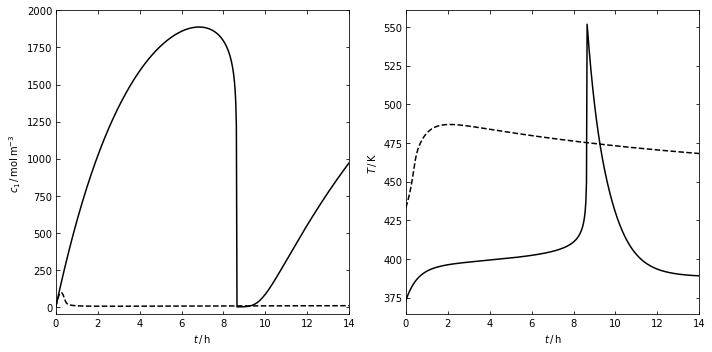

In [52]:
fig, ax = plt.subplots(1, 2, figsize = (10, 5))
ax[0].plot(sol_1.t / 3600, sol_1.y[0], color = 'black')
ax[0].plot(sol_2.t / 3600, sol_2.y[0], color = 'black', linestyle = '--')
ax[0].tick_params(axis="y",direction="in", right = True)
ax[0].tick_params(axis="x",direction="in", top = True)
ax[0].set_ylabel(r'$c_1\,/\,\mathrm{mol\,m^{-3}}$')
ax[0].set_xlabel(r'$t \,/\,\mathrm{h}$')
ax[0].set_xlim(0, 14)
ax[0].set_ylim(-50, 2000)

ax[1].plot(sol_1.t / 3600, sol_1.y[-1], color = 'black')
ax[1].plot(sol_2.t / 3600, sol_2.y[-1], color = 'black', linestyle = '--')
ax[1].tick_params(axis="y",direction="in", right = True)
ax[1].tick_params(axis="x",direction="in", top = True)
ax[1].set_ylabel(r'$T\,/\,\mathrm{K}$')
ax[1].set_xlabel(r'$t \,/\,\mathrm{h}$')
ax[1].set_xlim(0, 14)
plt.tight_layout()
plt.show()


<b>Erratum:</b> Bei der Erstellung der Abbildung 10.3 in Beispiel 10.1 im Lehrbuch hat sich ein Fehler eingeschlichen. Deshalb weichen die quantitativen Verläufe voneinander ab; qualitativ sind die Verläufe jedoch gleich.